Analyze Xenium data
===================

In [ ]:
import scanpy as sc
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Download the Feature-cell Matrix (HDF5) and the Cell summary file (CSV) from the [Xenium breast cancer tumor microenvironment Dataset](https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast).

You need these 2 files in a new folder `tutorial_data` in the same path as your notebook. 
- `Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5`
- `Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv`

The following lines create the folder structure which can be used to load the data.

In [33]:
# !mkdir tutorial_data
# !mkdir tutorial_data/xenium_data
# !wget -P tutorial_data/xenium_data/https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5
# !wget -P tutorial_data/xenium_data/https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz
# !tar -xzf tutorial_data/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz -C tutorial_data/xenium_data/.

In [2]:
adata = sc.read_10x_h5(filename='/tutorial_data/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5')

In [3]:
df = pd.read_csv('/tutorial_data/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv')

In [4]:
df.set_index(adata.obs_names, inplace=True)
#adata.obs.index.name = None
adata.obs = df.copy()

In [5]:
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

Calculate quality control metrics
---------------------------------

Make the variable names unique using the method `anndata.var_names_make_unique`.
Obtain the mitochondrial genes using their names prefixed with "mt-".
Calculate the quality control metrics on the `anndata.AnnData` using `scanpy.pp.calculate_qc_metrics`.

In [7]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"],percent_top=(50, 100, 200, 300), inplace=True)

Plot the "total_counts" and "n_genes_by_counts" from `anndata.obs`.
The first subplot shows `adata.obs["total_counts"]`, the second `adata.obs["n_genes_by_counts"]`.

c:\Users\laure\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

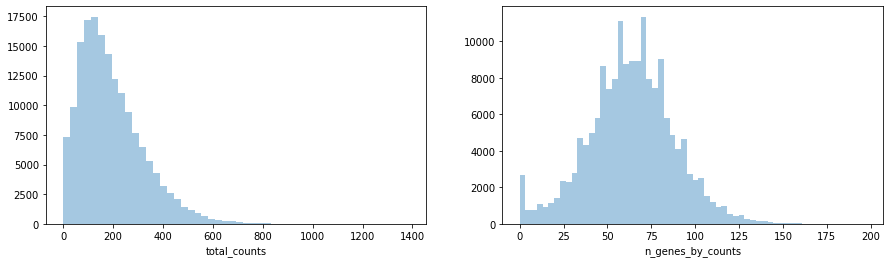

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)
sns.distplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    bins=60,
    ax=axs[1],
)

Filter the cells based on the minimum number of counts required using `scanpy.pp.filter_cells`. Filter the genes based on the minimum number of cells required with `scanpy.pp.filter_genes`. The parameters for the both were specified based on the plots above. They were set to filter out the cells and genes with minimum counts and minimum cells respectively.

In [9]:
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)

Normalize counts per cell using `scanpy.pp.normalize_total`.

Logarithmize, do principal component analysis, compute a neighborhood graph of the observations using `scanpy.pp.log1p`, `scanpy.pp.pca` and `scanpy.pp.neighbors` respectively.

Use `scanpy.tl.umap` to embed the neighborhood graph of the data and cluster the cells into subgroups employing `scanpy.tl.leiden`.

In [10]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

c:\Users\laure\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Visualize annotation on UMAP and spatial coordinates
----------------------------------------------------

Subplot with scatter plot in UMAP (Uniform Manifold Approximation and Projection) basis. The embedded points were colored, respectively, according to the total counts, number of genes by counts, and leiden clusters in each of the subplots. This gives us some idea of what the data looks like.

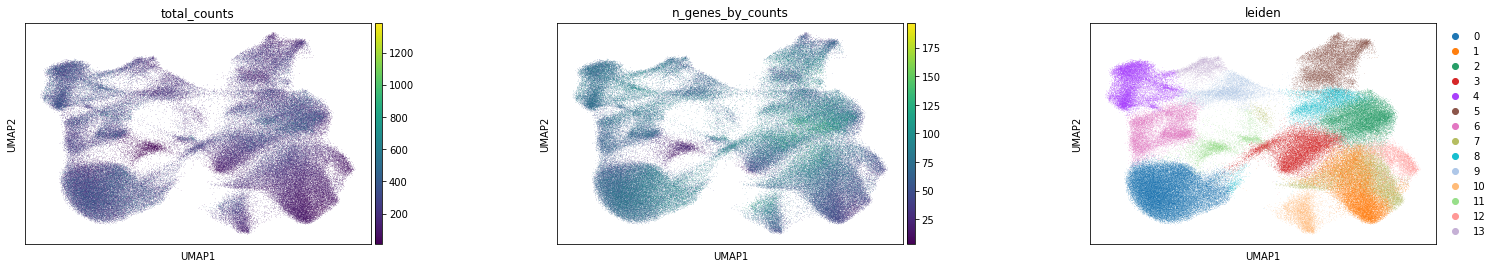

In [11]:
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.4,
)

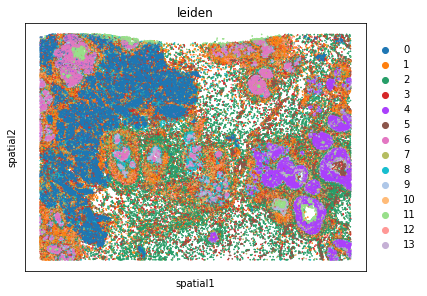

In [13]:
sq.pl.spatial_scatter(adata, library_id="spatial", shape=None,color=[
        "leiden",
    ],
    wspace=0.4,)

Computation of spatial statistics
---------------------------------

Building the spatial neighbors graphs
-------------------------------------

This example shows how to compute centrality scores, given a spatial graph and cell type annotation.

The scores calculated are closeness centrality, degree centrality and clustering coefficient with the following properties:
* closeness centrality - measure of how close the group is to other nodes.
* clustering coefficient - measure of the degree to which nodes cluster together.
* degree centrality - fraction of non-group members connected to group members.

All scores are descriptive statistics of the spatial graph.

This dataset contains Leiden cluster groups' annotations in `anndata.AnnData.obs`, which are used for calculation of centrality scores.

First, we need to compute a connectivity matrix from spatial coordinates to calculate the centrality scores. We can use `squidpy.gr.spatial_neighbors` for this purpose. We use the `coord_type="generic"` based on the data and the neighbors are classified with Delaunay triangulation by specifying `delaunay=True`.

In [14]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)

Compute centrality scores
-------------------------

Centrality scores are calculated with `squidpy.gr.centrality_scores`, with the Leiden groups as clusters.

In [15]:
sq.gr.centrality_scores(adata, cluster_key="leiden")

The results were visualized by plotting the average centrality, closeness centrality, and degree centrality using `squidpy.pl.centrality_scores`.

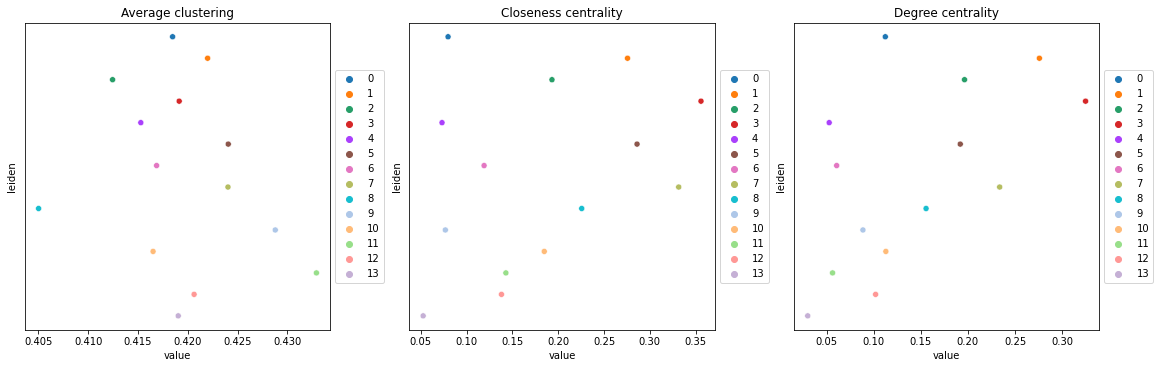

In [16]:
sq.pl.centrality_scores(adata, cluster_key="leiden", figsize=(16, 5))

Compute co-occurrence probability
---------------------------------

This example shows how to compute the co-occurrence probability.

The co-occurrence score is defined as:

\begin{equation}
\frac{p(exp|cond)}{p(exp)}
\end{equation}
where $p(exp|cond)$ is the conditional probability of observing a
cluster $exp$ conditioned on the presence of a cluster $cond$, whereas
$p(exp)$ is the probability of observing $exp$ in the radius size of
interest. The score is computed across increasing radii size around each
cell in the tissue.

We can compute the co-occurrence score with `squidpy.gr.co_occurrence`.
Results of co-occurrence probability ratio can be visualized with `squidpy.pl.co_occurrence`. The '3' in the $\frac{p(exp|cond)}{p(exp)}$ represents a Leiden clustered group.

We can further visualize tissue organization in spatial coordinates with `squidpy.pl.spatial_scatter`, with an overlay of the expressed genes which were colored in consonance with the Leiden clusters.

In [17]:
adata_subsample = sc.pp.subsample(adata, fraction=0.5, copy=True)

100%|██████████| 861/861 [15:08<00:00,  1.06s/]


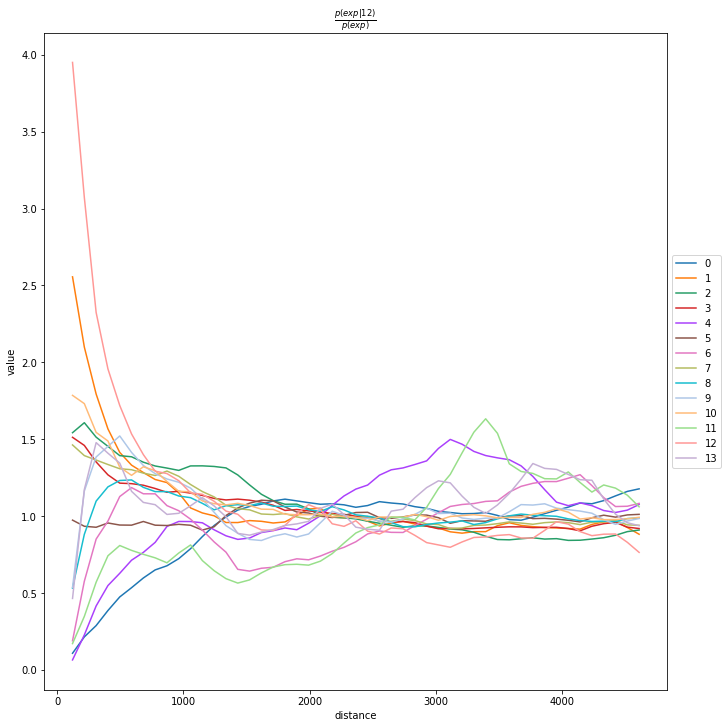

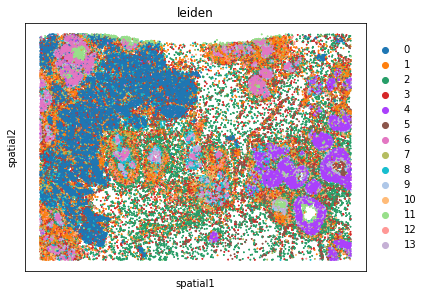

In [18]:
sq.gr.co_occurrence(
    adata_subsample,
    cluster_key="leiden",
)
sq.pl.co_occurrence(
    adata_subsample,
    cluster_key="leiden",
    clusters="12",
    figsize=(10, 10),
)
sq.pl.spatial_scatter(
    adata_subsample,
    color="leiden",
    shape=None,
    size=2,
)

Neighbors enrichment analysis
-----------------------------

This example shows how to run the neighbors enrichment analysis routine.

It calculates an enrichment score based on proximity on the connectivity graph of cell clusters. The number of observed events is compared against $N$ permutations and a *z-score* is computed.

This dataset contains cell type annotations in `anndata.Anndata.obs` which are used for calculation of the neighborhood enrichment. We calculate the neighborhood enrichment score with `squidpy.gr.nhood_enrichment`.

In [19]:
sq.gr.nhood_enrichment(adata, cluster_key="leiden")

100%|██████████| 1000/1000 [00:25<00:00, 38.50/s]


And visualize the results with `squidpy.pl.nhood_enrichment`.

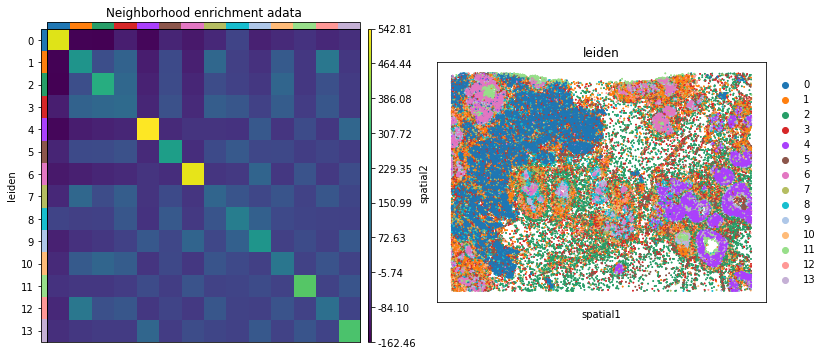

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
sq.pl.nhood_enrichment(
    adata,
    cluster_key="leiden",
    figsize=(8, 8),
    title="Neighborhood enrichment adata",
    ax=ax[0],
)
sq.pl.spatial_scatter(adata_subsample, color="leiden", shape=None, size=2, ax=ax[1])

Compute Moran's I score
-----------------------

This example shows how to compute the Moran's I global spatial auto-correlation statistics.

The Moran's I global spatial auto-correlation statistics evaluates whether features (i.e. genes) shows a pattern that is clustered, dispersed or random in the tissue are under consideration.

We can compute the Moran's I score with `squidpy.gr.spatial_autocorr` and `mode = 'moran'`. We first need to compute a spatial graph with `squidpy.gr.spatial_neighbors`. We will also subset the number of genes to evaluate.

In [22]:
sq.gr.spatial_neighbors(adata_subsample, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata_subsample,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
adata_subsample.uns["moranI"].head(10)

100%|██████████| 100/100 [34:39<00:00, 20.80s/]


,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
KRT7,0.696668,0.0,0.000004,0.0,0.009901,0.000008,0.0,0.0,0.009965
SCD,0.671975,0.0,0.000004,0.0,0.009901,0.000009,0.0,0.0,0.009965
FOXA1,0.659014,0.0,0.000004,0.0,0.009901,0.000008,0.0,0.0,0.009965
FASN,0.653400,0.0,0.000004,0.0,0.009901,0.000006,0.0,0.0,0.009965
EPCAM,0.641954,0.0,0.000004,0.0,0.009901,0.000009,0.0,0.0,0.009965
TACSTD2,0.638978,0.0,0.000004,0.0,0.009901,0.000007,0.0,0.0,0.009965
CEACAM6,0.631554,0.0,0.000004,0.0,0.009901,0.000009,0.0,0.0,0.009965
ERBB2,0.628083,0.0,0.000004,0.0,0.009901,0.000009,0.0,0.0,0.009965
KRT8,0.619555,0.0,0.000004,0.0,0.009901,0.000008,0.0,0.0,0.009965
LUM,0.593700,0.0,0.000004,0.0,0.009901,0.000007,0.0,0.0,0.009965


We can visualize some of those genes with `squidpy.pl.spatial_scatter`. We could also pass `mode = 'geary'` to compute a closely related auto-correlation statistic, [Geary's C](https://en.wikipedia.org/wiki/Geary%27s_C). See `squidpy.gr.spatial_autocorr` for more information.

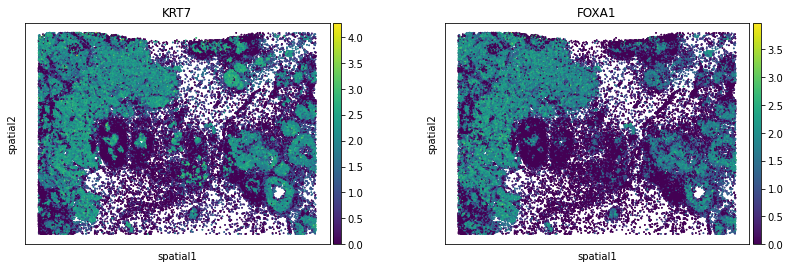

In [30]:
sq.pl.spatial_scatter(
    adata_subsample,
    library_id="spatial",
    color=[
        "KRT7",
        "FOXA1",
    ],
    shape=None,
    size=2,
    img=False,
)